In [5]:
##################################################
# CVsim.m - Cyclic voltammetry simulation
# Peter Attia
# Based on Bard and Faulkner, Appendix B
# EC mechanism
# Updated September 20, 2020
##################################################

import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import random
from IPython.display import clear_output


def Gradient2ndOrder(f,dx):
  f = np.asanyarray(f)
  N = f.ndim  # number of dimensions
  axes = tuple(range(N))

  len_axes = len(axes)
  dx = [dx] * len_axes
  outvals = []

  # create slice objects --- initially all are [:, :, ..., :]
  slice1 = [slice(None)]*N
  slice2 = [slice(None)]*N
  slice3 = [slice(None)]*N
  slice4 = [slice(None)]*N

  for axis, ax_dx in zip(axes, dx):

      # result allocation
      out = np.empty_like(f, dtype=float)

      # Numerical differentiation: 2nd order interior
      slice1[axis] = slice(1, -1)
      slice2[axis] = slice(None, -2)
      slice3[axis] = slice(1, -1)
      slice4[axis] = slice(2, None)
      out[tuple(slice1)] = (f[tuple(slice4)] + f[tuple(slice2)] - 2*f[tuple(slice1)]) / (ax_dx)


      out = GradientEdge1D(out, axis, f, ax_dx, slice1,slice2,slice3,slice4)
      outvals.append(out)

      # reset the slice object in this dimension to ":"
      slice1[axis] = slice(None)
      slice2[axis] = slice(None)
      slice3[axis] = slice(None)
      slice4[axis] = slice(None)
  return outvals

def GradientEdge1D(out, axis, f, dx_0, slice1,slice2,slice3,slice4):
      slice1[axis] = 1
      slice2[axis] = 2
      slice3[axis] = 1

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      slice1[axis] = 0
      slice2[axis] = 1
      slice3[axis] = 0

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
      out[tuple(slice1)]=-1*(d1-d2)/dx_0

      slice1[axis] = -2
      slice2[axis] = -2
      slice3[axis] = -3

      d1 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      slice1[axis] = -1
      slice2[axis] = -1
      slice3[axis] = -2

      d2 = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

      out[tuple(slice1)]=(d1-d2)/dx_0
      return out


#scan variables
D        = .726E-5;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
etai     = +0.5;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf     = -0.5;   # [=] V, final overpotential (relative to redox potential). Default = -0.2
v        = .05;   # [=] V/s, sweep rate. Default = 1E-3
C_inital = 1e-3;    # [=] mol/L, initial concentration of O. Default = 1.0
TempK    = 298.15; # [=] K, temperature. Default = 298.15

## Fitting VARIABLES ##
n      = 1.0;    # [=] number of electrons transfered. Default = 1
alpha  = 0.51;    # [=] dimensionless charge-transfer coefficient. Default = 0.5
k0     = np.power(10,-1.3);   # [=] cm/s, electrochemical rate constant. Default = 1E-2
kc     = 1E-3;   # [=] 1/s, chemical rate constant. Default = 1E-3
area   =  .5*1 #cm^2     
OCP    = 0 #v

## PHYSICAL CONSTANTS ##
Faraday = 96485;   # [=] C/mol, Faraday's constant
R_ideal = 8.3145;  # [=] J/mol-K, ideal gas constant
f       = Faraday/(R_ideal*TempK); # [=] 1/V, normalized Faraday's constant at room temperature

## SIMULATION VARIABLES ##
L      = 500;    # [=] number of iterations per t_k (pg 790). Default = 500
DM     = 0.45;   # [=] model diffusion coefficient (pg 788). Default = 0.45

EWidth_um   = 3       # [=] um  width of electrode
ELength_um  = 10      # [=] um  length of the electrode
gridSize_um = 100     # [=] um  max dimension that contains the electrode.
Dx_um     = .2    # [=] um Grid step
 

In [15]:
etai   -= OCP;   # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf   -= OCP;  # [=] V, final overpotential (relative to redox potential). Default = -0.2

EWidth    = EWidth_um   *1e-4     # convert to cm
gridSize  = gridSize_um *1e-4     # convert to cm
ELength   = ELength_um  *1e-4     # convert to cm
Dx        = Dx_um       *1e-4     # convert to cm
C         = C_inital    / 1000    # Convert C from mol/L to mol/cm3

## DERIVED CONSTANTS ##
tk       = 2*(etai-etaf)/v            # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
Dt       = Dx*Dx*DM/D *100                # [=] s, delta time
L        = int(np.ceil(tk/Dt ))       # [=] number of time steps
numBoxs  = int(np.ceil(gridSize/Dx))  # number of boxes (pg 792-793). If L~200, j=65

## REVERSIBILITY PARAMETERS ##
normedF  = Faraday/(R_ideal*TempK) # [=] 1/V, normalized Faraday's constant at room temperature
ktk    = kc*tk                     # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
km     = ktk/L                     # normalized dimensionless kinetic parameter (see bottom of pg 797)
Lambda = k0/(D*normedF*v)**0.5     # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)

## CHEMICAL REVERSIBILITY WARNING ##
if km>0.1:
    print('k_c*t_k/l equals ' + str(km) +', which exceeds the upper limit of 0.1 (see B&F, pg 797)')

print(f'Dx: {Dx*1e4:.4f} um')
print(f'timeSteps: { L } of {Dt} s')
print(f'Number of grid cells: {numBoxs}')

Dx: 0.2000 um
timeSteps: 16134 of 0.0024793388429752068 s
Number of grid cells: 500


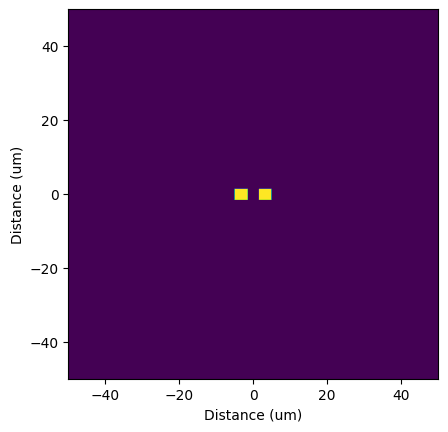

In [16]:
mask     = np.zeros((numBoxs,numBoxs))
m1=int(np.ceil(numBoxs/2-EWidth/2/Dx))
m2=int(np.ceil(numBoxs/2+EWidth/2/Dx))

m1x=int(np.ceil(numBoxs/2-ELength/2/Dx))
m2x=int(np.ceil(numBoxs/2+ELength/2/Dx))
for i in range(m1,m2):
    mask[i,m1x:m2x]=1

for i in range(m1,m2):
    mask[m1x:m2x,i]=0

plt.imshow(mask, extent=[gridSize/-2*1e4,gridSize/2*1e4,gridSize/-2*1e4,gridSize/2*1e4])
plt.xlabel('Distance (um)')
plt.ylabel('Distance (um)')
plt.show()

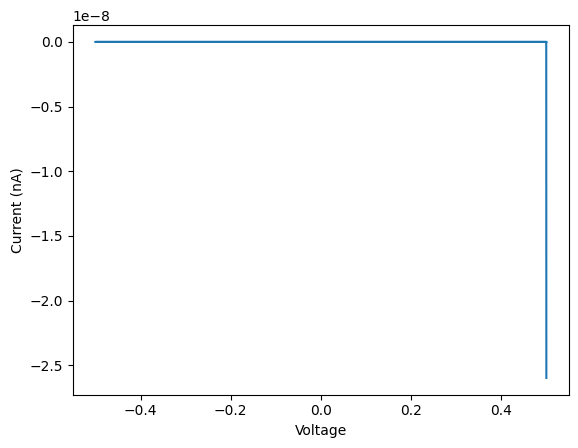

KeyboardInterrupt: 

In [ ]:
#def SimulateCurve3D(gap):
gap=1
t = Dt * np.linspace( 0,L,L)             # time vector
eta1 = etai - v*t      # overpotential vector, negative scan
eta2 = etaf + v*t      # overpotential vector, positive scan
eta = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai]])#,eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
Enorm = eta*normedF          # normalized overpotential
kf = k0*np.exp(  -alpha *n*Enorm)*gap # [=] cm/s, fwd rate constant (pg 799)
kb = k0*np.exp((1-alpha)*n*Enorm) *gap# [=] cm/s, rev rate constant (pg 799)
kRateNorm = (1 + Dx/D*(kf + kb) )

O = C*np.ones((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of O
R =  np.zeros((numBoxs,numBoxs,int(numBoxs/2))) # [=] mol/cm^3, concentration of R

IO = np.zeros((len(eta))) # [=] mol/cm^2-s, flux of O at the surface

for i_time in range(0,len(eta)):
    gradients = Gradient2ndOrder(O,1)
    O = O + DM*(gradients[0]+gradients[1]+gradients[2])
    gradients=0
    gradients = Gradient2ndOrder(R,1)
    R = R + DM*(gradients[0]+gradients[1]+gradients[2]) - km * R
    gradients=0
    # Update flux
    J= (( kf[i_time]*O[:,:,1] - kb[i_time]*R[:,:,1] ) / kRateNorm[i_time])*mask

    # Update surface concentrations
    O[:,:,0] = O[:,:,1] - J*Dx/D
    R[:,:,0] = R[:,:,1] + J*Dx/D - km*R[:,:,0]
    IO[i_time] = np.sum(J)*Dx*Dx

    if i_time%1000==0:
        clear_output(wait=False)
        fix,ax=plt.subplots(1,3)
        ax[0].plot(eta[:i_time],n*Faraday*IO[:i_time]*-1e9)
        ax[0].set_xlabel('Voltage')
        ax[0].set_ylabel('Current (nA)')
        
        ax[1].imshow(R[:,:,1], extent=[gridSize/-2*1e4,gridSize/2*1e4,gridSize/-2*1e4,gridSize/2*1e4])
        ax[2].imshow(O[:,:,1], extent=[gridSize/-2*1e4,gridSize/2*1e4,gridSize/-2*1e4,gridSize/2*1e4])
        plt.show()
         

plt.plot(eta,n*Faraday*IO*-1e9)
plt.xlabel('Voltage')
plt.ylabel('Current (nA)')
plt.show()

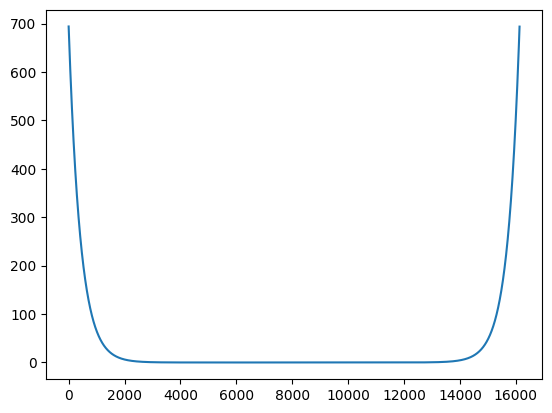

In [20]:
plt.plot(kb)

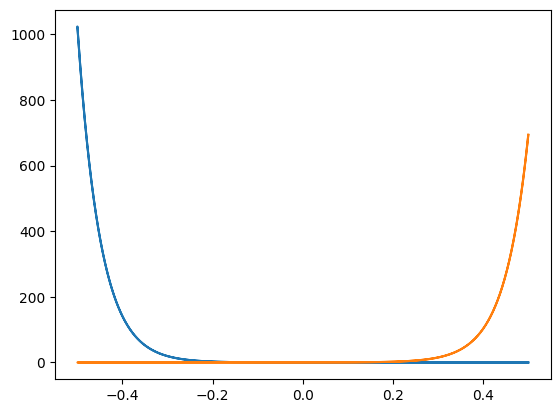

In [14]:
plt.plot(eta,kf)
plt.plot(eta,kb)